In [1]:
import numpy as np
import coupled_LDS
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import pymanopt 
import autograd.numpy as anp 

In [19]:
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
# try:
#     from sippy_unipi import system_identification
# except ImportError:
#     import os
#     import sys

#     sys.path.append(os.pardir)
#     from sippy_unipi import system_identification


# Standard LDS data generation + testing

In [38]:
S = 500
T = 100
K1 = 2
K2 = 2
K = K1 + K2
D = 20
M = 2

In [39]:
# generate dynamic matrix A
eigvals1 = generate_eigenvalues(K1, R=1) # in disc of radius R = 1
eigvals2 = generate_eigenvalues(K2, R=1) 

LDS = coupled_LDS.coupled_LDS(D, K1, K2, M)
true_A = LDS.generate_dynamics_matrix(eigvals1, eigvals2, disconnected=False)
print(true_A)

# generate known inputs 
u = LDS.generate_inputs(S,T)

true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R = LDS.generate_other_parameters()
print(np.round(true_C.T @ true_C,5)) # C is orthogonal

[[-0.70750524  0.3566766   0.          0.        ]
 [-0.3566766  -0.70750524  0.          0.        ]
 [ 0.58698642 -0.32005281  0.69016282 -0.17678717]
 [-0.11241513 -1.98493285  0.17678717  0.69016282]]
[[ 1. -0. -0. -0.]
 [-0.  1. -0.  0.]
 [-0. -0.  1.  0.]
 [-0.  0.  0.  1.]]


In [40]:
true_x, true_y = LDS.generate_latents_and_observations(S, T, u, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)


In [49]:
print(R @ sys_id.B)
print(true_B)

[[-0.24902369  0.82724094]
 [ 0.36049673 -0.05744297]
 [ 0.20248291 -0.88430593]
 [-0.22285356  0.31825767]]
[[ 0.50593731 -0.62760845]
 [-0.12230187  1.09002102]
 [ 0.          0.        ]
 [ 0.          0.        ]]


[[ 1.00000000e+00  2.77555756e-17  1.66533454e-16 -1.24900090e-16]
 [ 2.77555756e-17  1.00000000e+00 -1.31838984e-16 -1.59594560e-16]
 [ 1.66533454e-16 -1.31838984e-16  1.00000000e+00 -6.93889390e-17]
 [-1.24900090e-16 -1.59594560e-16 -6.93889390e-17  1.00000000e+00]]
[[-7.07312473e-01  3.60751829e-01  0.00000000e+00  0.00000000e+00]
 [-3.51978410e-01 -7.07312473e-01  0.00000000e+00  0.00000000e+00]
 [ 3.26291250e-04 -1.37194756e+00  6.87611969e-01  1.57084210e-01]
 [ 9.15950602e-01 -1.29933178e+00 -1.87810932e-01  6.87611969e-01]]
‖C_err‖₂ = 0.06569023301136862
‖C_err‖₂ = 2.8343903642327626
‖A_err‖₂ = 0.06266194543239355
‖A_err‖₂ = 3.2180176030552587
‖A_err‖₂ = 3.134720007689463
2.282601344554461


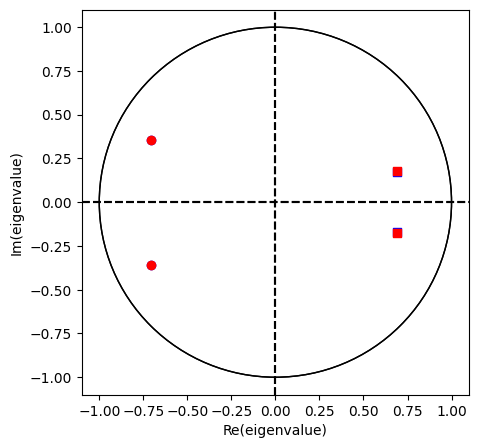

In [48]:
method = "MOESP"
U = u.reshape(-1, M).T
true_y_zerom = true_y-np.mean(true_y, axis=(0,1), keepdims=True)
Y = true_y_zerom.reshape(-1, D).T
U = u.reshape(-1,M).T
sys_id = system_identification(Y, U, method, SS_fixed_order=K, SS_p=2*K,             # # past block‐rows
    SS_f=2*K)

P = np.linalg.pinv(sys_id.C) @ true_C    # solves min ||C_true - C_hat T||_F
A_aligned = np.linalg.inv(P) @ sys_id.A @ P
C_aligned = sys_id.C @ P
# A_Schur, V = sl.schur(A_aligned.T, output='real')

Q, R = np.linalg.qr(sys_id.C, mode='reduced')   # Q: p×n, R: n×n
P = np.linalg.inv(R)                     # P is n×n and invertible
C_orth = sys_id.C @ P
A_hat = R @ sys_id.A @ P
A_Schur, V = sl.schur(A_hat.T, output='real')
A_Schur = A_Schur.T

print(C_orth.T @ C_orth)
print(A_Schur)

# 5) Measure your error
print("‖C_err‖₂ =", np.linalg.norm(C_aligned - true_C))
print("‖C_err‖₂ =", np.linalg.norm(C_orth - true_C))
print("‖A_err‖₂ =", np.linalg.norm(A_aligned - true_A))
print("‖A_err‖₂ =", np.linalg.norm(A_hat - true_A))
print("‖A_err‖₂ =", np.linalg.norm(A_Schur.T - true_A))


print(np.linalg.norm(R @ sys_id.B - true_B))


fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A_Schur[:K1,:K1]), np.linalg.eigvals(A_Schur[K1:,K1:]), color='blue')
# plot_eigenvalues(axes, np.linalg.eigvals(A_aligned[:K1,:K1]), np.linalg.eigvals(A_aligned[K1:,K1:]), color='green')
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

In [42]:
print(np.linalg.eigvals(sys_id.A))
print(np.linalg.eigvals(true_A))


[-0.70731247+0.35633812j -0.70731247-0.35633812j  0.68761197+0.17176185j
  0.68761197-0.17176185j]
[-0.70750524+0.3566766j  -0.70750524-0.3566766j   0.69016282+0.17678717j
  0.69016282-0.17678717j]


In [64]:
# smart initialization
# initialize C from PCA
y_flatten = true_y.reshape(true_y.shape[0] * true_y.shape[1], true_y.shape[2]) 
y_mean   = y_flatten.mean(axis=0, keepdims=True)
y_pca       = y_flatten - y_mean
Y_cov = (y_pca.T @ y_pca) / y_pca.shape[0]              # Gram / inner‑product matrix
eigvals, eigvecs = np.linalg.eigh(Y_cov)     # ascending order
C_PCA = eigvecs[:, -K:][:, ::-1]             # take largest K, flip to descending D x K

x_PCA = np.zeros((S,T,K))
for s in range(S):
    x_PCA[s] = true_y[s] @ C_PCA

x_PCA_before = x_PCA[:,:-1,:]
x_PCA_before = x_PCA_before.reshape(x_PCA_before.shape[0] * x_PCA_before.shape[1], x_PCA_before.shape[2])
x_PCA_after = x_PCA[:,1:,:]
x_PCA_after = x_PCA_after.reshape(x_PCA_after.shape[0] * x_PCA_after.shape[1], x_PCA_after.shape[2])


reg = LinearRegression().fit(x_PCA_before, x_PCA_after)
A_REG = reg.coef_

# # x_aug = 
# A_REG[:K1,K1:] = 0


A_Schur, V = sl.schur(A_REG.T, output='real')
print(A_Schur.T)

print(np.linalg.eigvals(true_A))
print(np.linalg.eigvals(A_REG))
print(np.linalg.eigvals(A_Schur))

# CHECK INITIAL ELBO FOR A_REG VS RANDOM A - see how bad local optima

[[-0.17690346  0.19635239  0.          0.        ]
 [-0.03148615 -0.17690346  0.          0.        ]
 [ 0.02603372  0.03489003  0.00781514  0.        ]
 [-0.00785734  0.07742953  0.00654034  0.02094011]]
[-0.70750524+0.3566766j  -0.70750524-0.3566766j   0.69016282+0.17678717j
  0.69016282-0.17678717j]
[-0.17690346+0.07862812j -0.17690346-0.07862812j  0.00781514+0.j
  0.02094011+0.j        ]
[-0.17690346+0.07862812j -0.17690346-0.07862812j  0.00781514+0.j
  0.02094011+0.j        ]


In [34]:
print(true_C.shape)
print(np.linalg.matrix_rank(C_PCA))
print(np.linalg.matrix_rank(true_C))
check_C = np.concatenate([true_C, C_PCA], axis=1)
print(check_C.shape)
print(np.linalg.matrix_rank(check_C))

U1,S1,V1 = np.linalg.svd(true_C)
U2,S2,V2 = np.linalg.svd(C_PCA)
U3,S3,V3 = np.linalg.svd(check_C)
print(S1)
print(S2)
print(S3)

def max_principal_angle(A, B, tol=None):
    """
    Compute the maximum principal angle (in radians) between Col(A) and Col(B).
    Small angles ≈ 0 ⇒ the subspaces nearly coincide.
    """
    # Orthonormal bases from SVD
    UA, _, _ = np.linalg.svd(A, full_matrices=False)
    UB, _, _ = np.linalg.svd(B, full_matrices=False)

    # Singular values of QA^T QB are cosines of principal angles
    cosines = np.linalg.svd(UA.T @ UB, compute_uv=False)
    angles = np.arccos(np.clip(cosines, -1, 1))
    return np.degrees(angles.max())

print(max_principal_angle(true_C, C_PCA, tol=None))

(20, 4)
4
4
(20, 8)
8
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1.40549952 1.38602092 1.29198145 1.10695247 0.88014558 0.5751382
 0.28097333 0.15675168]
76.9769063051042


In [35]:
x = np.zeros((S, T, K))
y = np.zeros((S, T, D))

# true_B = np.zeros((K,M))
for s in range(S):
    x[s, 0] = np.random.multivariate_normal(np.zeros((K)), np.eye(K))
    y[s, 0] = true_C @ x[s, 0] + true_d 
    for i in range(1, T):
        x[s, i] = true_A @ x[s, i-1] + true_B @ u[s,i-1]
        y[s, i] = true_C @ x[s, i] + true_d

# true_y_zerom = true_y-np.mean(true_y, axis=(1,2), keepdims=True)
true_y_zerom = y-np.mean(y, axis=(0,1), keepdims=True)

import numpy as np

def block_hankel(data, i):
    # data: (d, N)
    d, N = data.shape
    cols = N - i + 1
    H = np.zeros((i*d, cols))
    for row in range(i):
        H[row*d:(row+1)*d, :] = data[:, row:row+cols]
    return H

# total time‐points
N = S*T

# 1) choose horizon
i = 2*K

U = u.reshape(-1, M).T
Y = true_y_zerom.reshape(-1, D).T


# 2) number of columns in both Y_p, U_p, Y_f
cols = N - i + 1
if cols <= 0:
    raise ValueError("Need N ≥ 2·i to build matching Hankels")

# 3) build full Hankels, then truncate to `cols` columns
Y_full = block_hankel(Y, i)      # shape (i*D, N-i+1)
U_full = block_hankel(U, i)      # shape (i*m, N-i+1)

Y_p = Y_full[:, :cols]           # take first cols columns
U_p = U_full[:, :cols]

# 4) for Y_f, start at time i, then take i rows, same cols
Y_shifted = Y[:, i:]             # shape (D, N-i)
Y_f_full = block_hankel(Y_shifted, i)  # shape (i*D, (N-i)-i+1 = cols)
Y_f = Y_f_full                   

# now Y_p, U_p, Y_f all have shape (_, cols)
# proceed exactly as before:

Z_p     = np.vstack([Y_p, U_p])            # ((iD + i m) × cols)
P_perp  = Z_p.T @ np.linalg.inv(Z_p @ Z_p.T) @ Z_p  # (cols × cols)
O_mat   = Y_f @ P_perp                      # (iD × cols)

# 3) SVD and extract extended observability
Uo, svals, Voh = np.linalg.svd(O_mat, full_matrices=False)
Uo_n = Uo[:, :K] @ np.diag(np.sqrt(svals[:K]))  # (iD, K)

# 4) Extract C_hat and estimate states
C_hat = Uo_n[:D, :]                   # first D rows


C_pinv = np.linalg.pinv(C_hat)
cols    = N - i

# Preallocate
X1 = np.zeros((K, cols))
X2 = np.zeros((K, cols))
U1 = np.zeros((m, cols))

print(cols)
print(Y_p.shape)
print(Y_f.shape)

for t in range(cols):
    # state at time t from past outputs y_t
    X1[:, t] = C_pinv @ Y_p[0:D, t]
    # state at time t+1 from future outputs y_{t+1}
    X2[:, t] = C_pinv @ Y_f[0:D, t]
    # input that drove x_t → x_{t+1}: index = t + (i-1)
    U1[:, t] = U[:, t + (i - 1)]


# stack and regress
Z     = np.vstack([X1, U1])                # shape ((K+m), cols)
Mbig  = X2 @ Z.T @ np.linalg.inv(Z @ Z.T)  # shape (K, K+m)
A_hat = Mbig[:, :K]
B_hat = Mbig[:,  K:]

# ——— done! ———
print("Estimated C (shape {}):".format(C_hat.shape))
print(np.linalg.norm(C_hat-true_C))
print("\nEstimated A (shape {}):".format(A_hat.shape))
print(np.linalg.norm(A_hat-true_A))
print(np.linalg.eigvals(A_hat))
print(np.linalg.eigvals(true_A))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9993 is different from 9985)

In [13]:
# Ho-Kalman SSID

L = 2*K
Mo = np.zeros((2*L-1,D,D))
H = np.zeros((L*D, L*D))


# true_y_zerom = true_y-np.mean(true_y, axis=(1,2), keepdims=True)
true_y_zerom = true_y-np.mean(true_y, axis=(0,1), keepdims=True)

for l in range(1,2*L):
    for s in range(S):
        for t in range(0,T-l):
            Mo[l-1] += np.outer(true_y_zerom[s,t+l,:], true_y_zerom[s,t,:])

    Mo[l-1] = Mo[l-1] / (T-l) 
    Mo[l-1] = Mo[l-1] / S

for i in range(L):
    for j in range(L):
        H[i*D:(i+1)*D,j*D:(j+1)*D] = Mo[i+j]


# ——— truncated SVD of the Future–Past Hankel ———
U, s, Vh = np.linalg.svd(H, full_matrices=False)
# choose latent dimension n by inspecting s:
n = K   # ← for example, pick the number of large singular values

# build the square‐root factors:
Sigma_sqrt = np.sqrt(np.diag(s[:n]))
# “observability” matrix O (shape (L*D, n))
O = U[:, :n] @ Sigma_sqrt
# “controllability” matrix P (shape (n, L*D))
W = Sigma_sqrt @ Vh[:n, :]

# ——— extract C from the first block of O ———
# the first D rows of O correspond to C
C_hat = O[:D, :]

# ——— estimate A via block‐regression ———
# split O into past (rows 0 through (L-1)*D) and future (rows D through L*D)
O_past   = O[:-D, :]   # shape ((L-1)*D, n)
O_future = O[ D:, :]   # shape ((L-1)*D, n)

# solve O_past * A^T ≈ O_future  →  A ≈ pinv(O_past) @ O_future
A_hat = np.linalg.pinv(O_past) @ O_future
# A_hat   = A_hat_T.T

# ——— done! ———
print("Estimated C (shape {}):".format(C_hat.shape))
print(np.linalg.norm(C_hat-true_C))
print("\nEstimated A (shape {}):".format(A_hat.shape))
print(np.linalg.norm(A_hat-true_A))
print(np.linalg.eigvals(A_hat))
print(np.linalg.eigvals(true_A))

# 4) Align via similarity transform T so C_hat T ≈ true_C
P = np.linalg.pinv(C_hat) @ true_C    # solves min ||C_true - C_hat T||_F
A_aligned = np.linalg.inv(P) @ A_hat @ P
C_aligned = C_hat @ P

# 5) Measure your error
print("‖C_err‖₂ =", np.linalg.norm(C_aligned - true_C))
print("‖A_err‖₂ =", np.linalg.norm(A_aligned - true_A))
# print(A_aligned)


Estimated C (shape (20, 4)):
10.894708404555635

Estimated A (shape (4, 4)):
3.961625385815901
[-0.17240403+0.88735838j -0.17240403-0.88735838j -0.32030258+0.83532745j
 -0.32030258-0.83532745j]
[-0.25091976+0.90142861j -0.25091976-0.90142861j  0.46398788+0.19731697j
  0.46398788-0.19731697j]
‖C_err‖₂ = 0.64644560980458
‖A_err‖₂ = 3.739324525947392


In [54]:
# # fitting from true parameters
# ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R, max_iter=5, verbosity=0)

ecll_new, ecll_old, elbo, ll_total, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, A_Schur, true_B, true_Q, true_mu0, true_Q0, C_orth, true_d, true_R, max_iter=50, verbosity=0)


# # fitting from random single parameter
# eigvals1_init = generate_eigenvalues(K1, R=1) # in disc of radius R = 1
# eigvals2_init = generate_eigenvalues(K2, R=1) 
# init_A = LDS.generate_dynamics_matrix(eigvals1_init, eigvals2_init, disconnected=False)

# # starting from C = PCA, A = REG, random other parameters
# init_B, init_Q, init_mu0, init_Q0, _, init_d, init_R = LDS.generate_other_parameters()
# ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, init_A, init_B, init_Q, init_mu0, init_Q0, C_PCA, init_d, init_R, max_iter=1, verbosity=0)

# import itertools
# perms = [list(p) for p in itertools.permutations([0, 1, 2, 3])]
# for perm in perms:
#     ecll, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, C_PCA[:,perm], true_d, true_R, max_iter=1, verbosity=2)


0
10
20
30
40


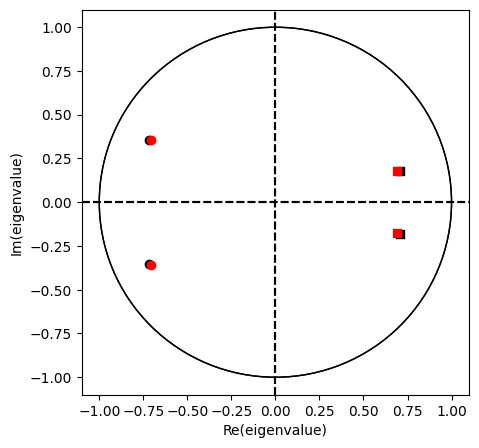

In [55]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

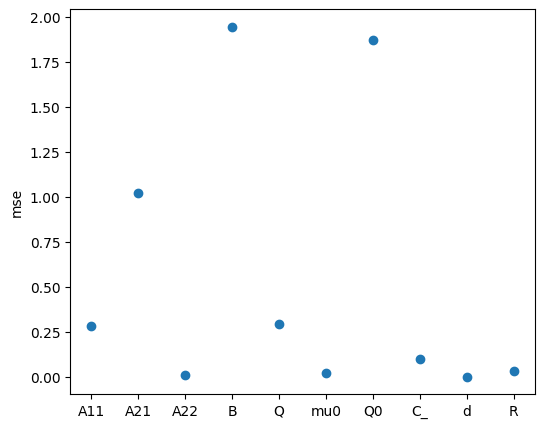

In [56]:
fig, axes = plt.subplots(figsize=(6,5))
plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

(50,)


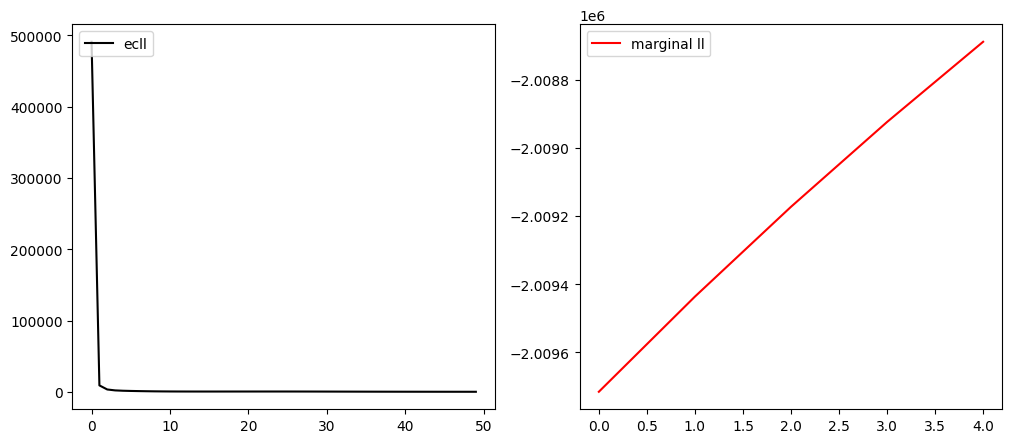

In [63]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
print(ll_total.sum(axis=1).shape)
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll')
axes[1].plot(elbo, color='red', label='marginal ll')
axes[1].plot(ll_total.sum(axis=1), color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

0
10
0
10
0
10
0
10
0
10
0
10
0
10
0
10
0
10
0
10


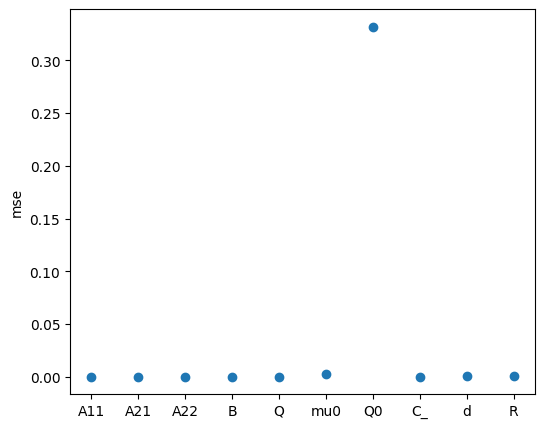

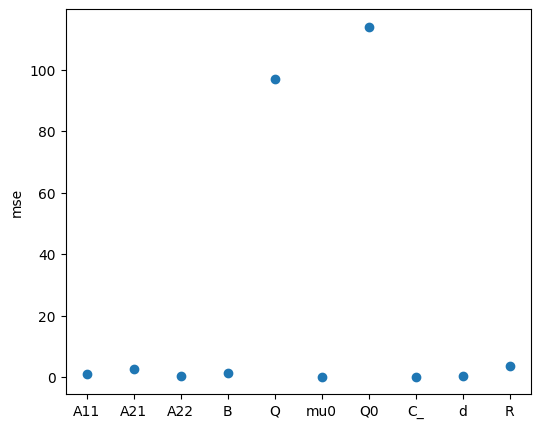

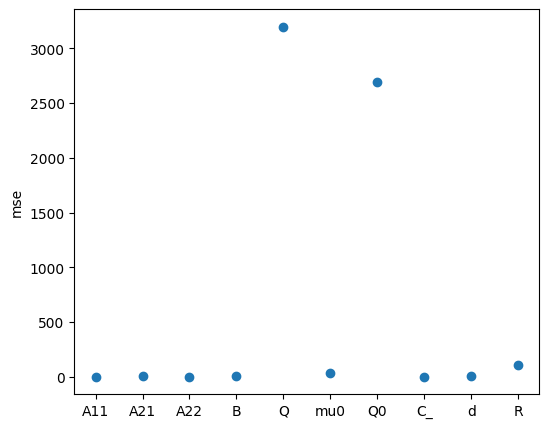

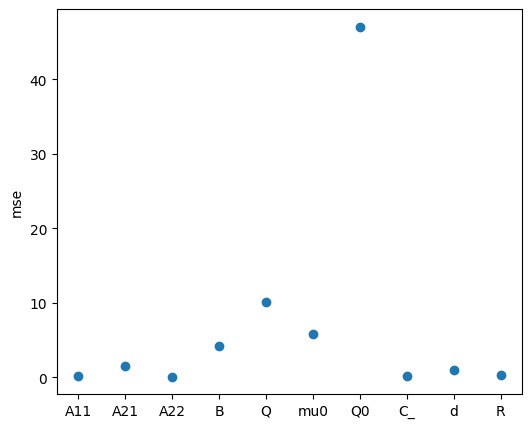

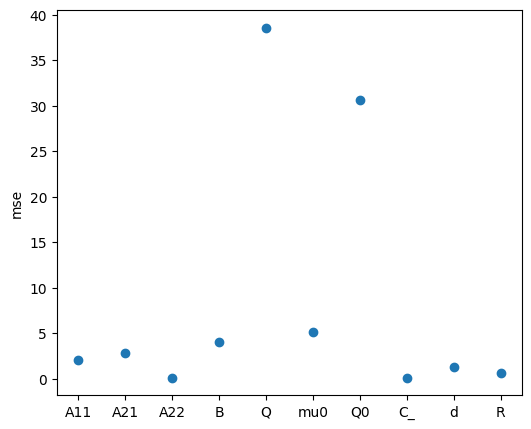

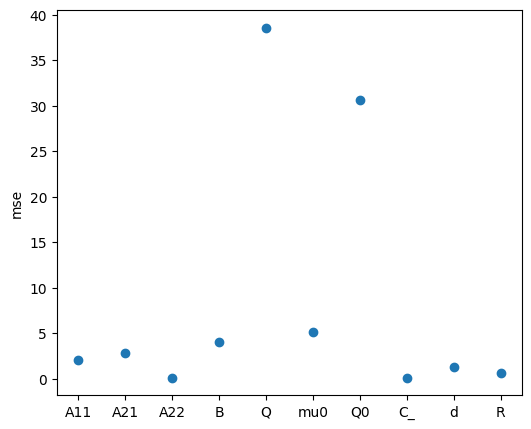

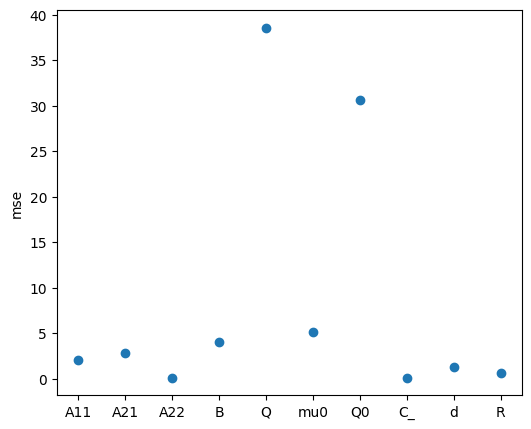

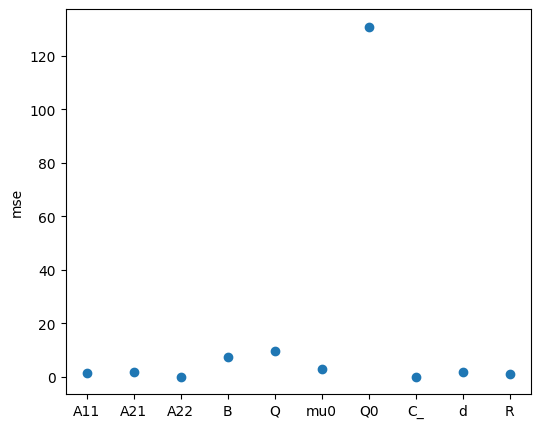

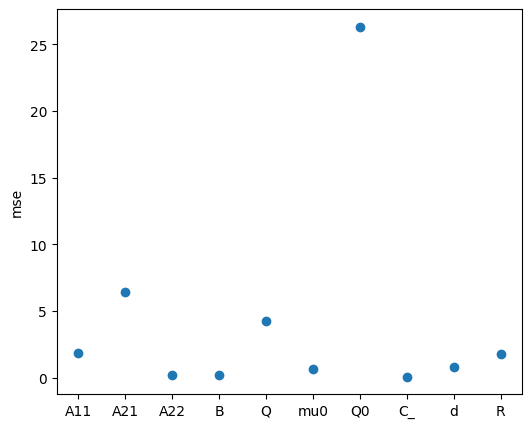

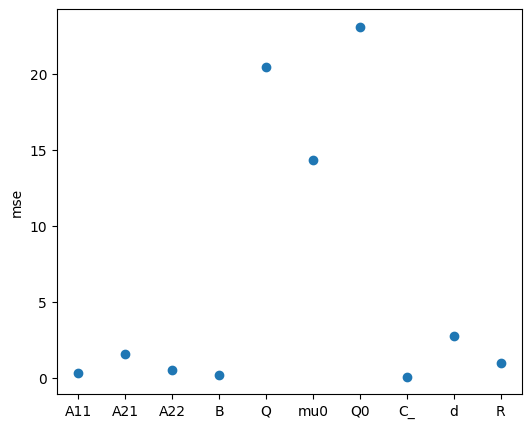

In [24]:
# OTHER INIT PARAMS ARE TRUE ONES, EXCEPT A, and except C which is PCA
N_model = 10
max_iter = 20
ecll_new = np.zeros((N_model, max_iter))
ecll_old = np.zeros((N_model, max_iter))
elbo = np.zeros((N_model, max_iter))
ll = np.zeros((N_model, max_iter, S))

init_B, init_Q, init_mu0, init_Q0, _, init_d, init_R = LDS.generate_other_parameters()

for model_n in range(N_model):
    if model_n == 0: # start from true param
        ecll_new[model_n], ecll_old[model_n], elbo[model_n], ll[model_n], A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R, max_iter=max_iter, verbosity=0)
        fig, axes = plt.subplots(figsize=(6,5))
        plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

    elif model_n in [1,2,3]: # complete random
        eigvals1_init = generate_eigenvalues(K1, R=1) # in disc of radius R = 1
        eigvals2_init = generate_eigenvalues(K2, R=1) 
        init_A = LDS.generate_dynamics_matrix(eigvals1_init, eigvals2_init, disconnected=False)
        init_B, init_Q, init_mu0, init_Q0, init_C, init_d, init_R = LDS.generate_other_parameters()
        ecll_new[model_n], ecll_old[model_n], elbo[model_n], ll[model_n], A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, init_A, init_B, init_Q, init_mu0, init_Q0, init_C, init_d, init_R, max_iter=max_iter, verbosity=0)
        fig, axes = plt.subplots(figsize=(6,5))
        plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)
    
    elif model_n in [4,5,6]: # A_REG, C_PCA

        ecll_new[model_n], ecll_old[model_n], elbo[model_n], ll[model_n], A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, A_REG, init_B, init_Q, init_mu0, init_Q0, C_PCA, init_d, init_R, max_iter=max_iter, verbosity=0)
        fig, axes = plt.subplots(figsize=(6,5))
        plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)
    
    else: # C_PCA
        eigvals1_init = generate_eigenvalues(K1, R=1) # in disc of radius R = 1
        eigvals2_init = generate_eigenvalues(K2, R=1) 
        init_A = LDS.generate_dynamics_matrix(eigvals1_init, eigvals2_init, disconnected=False)
        init_B, init_Q, init_mu0, init_Q0, _, init_d, init_R = LDS.generate_other_parameters()
        ecll_new[model_n], ecll_old[model_n], elbo[model_n], ll[model_n], A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, init_A, init_B, init_Q, init_mu0, init_Q0, C_PCA, init_d, init_R, max_iter=max_iter, verbosity=0)
        fig, axes = plt.subplots(figsize=(6,5))
        plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)     

Text(0.5, 1.0, 'ELBO')

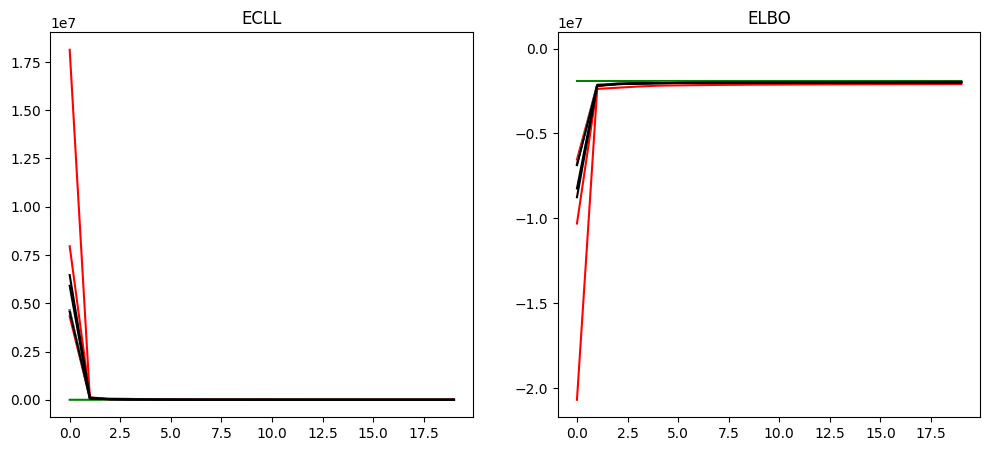

In [29]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
color = ['green','red','red','red','gray','gray', 'gray', 'black','black','black']
for model_n in range(N_model):
    axes[0].plot(ecll_new[model_n]-ecll_old[model_n], color=color[model_n], label='ecll')
    axes[1].plot(elbo[model_n], color=color[model_n], label='marginal ll')
    axes[1].plot(ll[[model_n]].sum(axis=1), color=color[model_n], label='marginal ll', linestyle='dashed')

axes[0].set_title('ECLL')
axes[1].set_title('ELBO')